In [1]:
#run this cell only once and then restart the runtime
#After restarting the runtime, run from the next cell and onwards (not this cell)

!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=5da77026fdf34c4e77797cf66048229c38ed016515a6aa1d8ab457a8e2912adf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ey1_x_y1/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
#importing all the necessary packages/sub-packages required

from google.colab import drive 
import os
from bs4 import BeautifulSoup
import csv
import random
import spacy
from spacy.util import minibatch, compounding
from pathlib import Path
from spacy import displacy
import itertools
from datetime import datetime
import pickle
import numpy as np
import pandas as pd

In [2]:
#keep the complete measeval zip file downloaded from github in your google drive in the Colab Notebooks folder.
#then run this cell to connect to google drive

drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
# to unzip the measeval.zip kept in your google drive in the Colab Notebooks folder.

!unzip "/content/drive/My Drive/Colab Notebooks/MeasEval-main.zip" -d "/content/drive/My Drive/Dataset"

In [4]:
#reading and storing all the text documents form train and eval folder

path_train = '/content/drive/My Drive/Dataset/MeasEval-main/data/train/text'
path_eval = '/content/drive/My Drive/Dataset/MeasEval-main/data/eval/text'


dict_train = {} #stores all text document from the train folder
dict_eval = {}  #stores all text document from the eval folder

#getting all the files in text folder inside train folder
for filename in os.listdir(path_train):
    data = open(path_train+'/'+filename,'r',encoding="utf8").read()
    soup = BeautifulSoup(data,'html.parser')
    text = soup.text
    filename = filename.rsplit('.', 1)[0]
    dict_train[filename] = text

print()
print("Train Text:")
row = 10
for key,val in dict_train.items():
    print(key,val)
    row-=1
    if row==0:
      break

#getting all the files in text folder inside eval folder
for filename in os.listdir(path_eval):
    data = open(path_eval+'/'+filename,'r',encoding="utf8").read()
    soup = BeautifulSoup(data,'html.parser')
    text = soup.text
    filename = filename.rsplit('.', 1)[0]
    dict_eval[filename] = text


print()
print("Eval Text:")
row = 10
for key,val in dict_eval.items():
    print(key,val)
    row-=1
    if row==0:
      break


Train Text:
S0378383912000130-3745 For the 8.5 mm beach the modelling produces a reasonably accurate trend at x = 1980 mm, while at x = 2780 mm the model fails to predict the initial sharp rise and the decline at the later stages of the swash. In this case the discrepancy between experimental and numerical results is probably caused by the modelling, most likely by the limited capability of the groundwater module.
S0925443913001385-1429 Human skin fibroblasts were cultured in DMEM medium (Dulbecco's modified Eagle's medium, Gibco) supplemented with 10% (v/v) fetal calf serum (FCS), 2 mM l-glutamine, 50 μg/ml uridine, 110 μg/ml pyruvate, 10,000 U/ml penicillin G and 10,000 μg/ml streptomycin.
S2213671113001306-1520 The Spectralis HRA/OCT device (Heidelberg Engineering) was used to acquire laser-interferometric reflectance OCT images of the retina and choroid, with resolutions comparable to a light microscopic section. Longitudinal and transversal line OCT scans through the center of th

In [5]:
#reading and storing all the tsv files form train and eval folder

train_tsv_path = '/content/drive/My Drive/Dataset/MeasEval-main/data/train/tsv'
eval_tsv_path = '/content/drive/My Drive/Dataset/MeasEval-main/data/eval/tsv'


train_label = {} #stores all tsv files from the train folder
eval_label = {} #stores all tsv files from the eval folder

#getting all the files in tsv folder inside train folder
for filename in os.listdir(train_tsv_path):
    print('#',end="")
    train_tsv_file = open(train_tsv_path+'/'+filename,encoding="utf8")
    read_tsv = csv.reader(train_tsv_file, delimiter="\t")
    annotset=-1
    flag=1
    temp_list=[]
    main_list=[]
    for row in read_tsv:
        if(flag):
            flag=0
            continue
        if row[1]!=annotset:
            annotset=row[1]
        
        if row[2]=='Qualifier':
            continue
        
        temp_tuple=(int(row[3]),int(row[4]),row[2])
        
        # removing all the overlapping entities
        if(temp_tuple not in temp_list):
          overlap=False
          for i in range(len(temp_list)):
            if( not ((temp_tuple[0]<temp_list[i][0] and temp_tuple[1]<temp_list[i][0]) or (temp_tuple[0]>temp_list[i][1] and temp_tuple[1]>temp_list[i][1]))):
              overlap=True
              break
          if(not overlap):
            temp_list.append(temp_tuple)

    train_label[filename[:-4]]=temp_list

print()
print("Train TSV:")
row=10
for key,val in train_label.items():
  row-=1
  print(key,val)
  if(row==0):
    break

#getting all the files in tsv folder inside eval folder
for filename in os.listdir(eval_tsv_path):
    print('#',end="")
    eval_tsv_file = open(eval_tsv_path+'/'+filename,encoding="utf8")
    read_tsv = csv.reader(eval_tsv_file, delimiter="\t")
    annotset=-1
    flag=1
    temp_list=[]
    main_list=[]
    for row in read_tsv:
        if(flag):
            flag=0
            continue
        if row[1]!=annotset:
            annotset=row[1]
        
        if row[2]=='Qualifier':
            continue
        
        temp_tuple=(int(row[3]),int(row[4]),row[2])
        
        # removing all the overlapping entities
        if(temp_tuple not in temp_list):
          overlap=False
          for i in range(len(temp_list)):
            if( not ((temp_tuple[0]<temp_list[i][0] and temp_tuple[1]<temp_list[i][0]) or (temp_tuple[0]>temp_list[i][1] and temp_tuple[1]>temp_list[i][1]))):
              overlap=True
              break
          if(not overlap):
            temp_list.append(temp_tuple)

    eval_label[filename[:-4]]=temp_list

print()
print("Eval TSV:")
row=10
for key,val in eval_label.items():
  row-=1
  print(key,val)
  if(row==0):
    break

#########################################################################################################################################################################################################################################
Train TSV:
S016412121300188X-4436 [(249, 252, 'Quantity'), (236, 245, 'MeasuredEntity'), (335, 338, 'Quantity'), (369, 434, 'MeasuredProperty'), (346, 368, 'MeasuredEntity')]
S0921818113002245-859 [(173, 191, 'Quantity'), (156, 169, 'MeasuredProperty'), (150, 155, 'MeasuredEntity')]
S2213671113000738-445 [(105, 110, 'Quantity'), (66, 76, 'MeasuredProperty'), (84, 89, 'MeasuredEntity')]
S0019103513005058-4098 [(418, 437, 'Quantity'), (408, 417, 'MeasuredProperty'), (385, 404, 'MeasuredEntity'), (465, 469, 'Quantity'), (453, 461, 'MeasuredProperty'), (441, 452, 'MeasuredEntity')]
S1359645413009816-2973 [(1020, 1038, 'Quantity'), (1016, 1019, 'MeasuredProperty'), (978, 1014, 'MeasuredEntity'), (1091, 1109, 'Quantity'), (1087, 1090, 'MeasuredProperty'), (1118,

In [6]:
#preparing the full training data as required by the model
full_train_data = []
for i in dict_train:
    dict_x = {}
    if i in train_label.keys():
        dict_x["entities"] = train_label[i]
        k = (dict_train[i], dict_x) # merging labels with documents
    else:
        dict_x["entities"] = []
        k = (dict_train[i], dict_x)
    full_train_data.append(k)
    
row=10
print()
print("Full Train Data:")
for i in range(row):
  print(full_train_data[i])

#preprocessing the test data
keys_eval_data=[] #stores filenames
X_eval_data=[] #stores corresponding documents
Y_eval_data=[] #stores labels
for i in dict_eval:
    dict_x = {}
    keys_eval_data.append(i)
    if i in eval_label.keys():
        dict_x["entities"] = eval_label[i]
        #keeping labels and documents separate
        X_eval_data.append(dict_eval[i])
        Y_eval_data.append(dict_x)
    else:
        dict_x["entities"] = []
        X_eval_data.append(dict_eval[i])
        Y_eval_data.append(dict_x)

row=10
print()
print("X and Y eval Data:")
for i in range(row):
  print(X_eval_data[i])
  print(Y_eval_data[i])


Full Train Data:
('For the 8.5 mm beach the modelling produces a reasonably accurate trend at x = 1980 mm, while at x = 2780 mm the model fails to predict the initial sharp rise and the decline at the later stages of the swash. In this case the discrepancy between experimental and numerical results is probably caused by the modelling, most likely by the limited capability of the groundwater module.', {'entities': [(8, 14, 'Quantity'), (15, 20, 'MeasuredEntity'), (79, 86, 'Quantity'), (75, 76, 'MeasuredProperty'), (25, 34, 'MeasuredEntity'), (101, 108, 'Quantity'), (97, 98, 'MeasuredProperty')]})
("Human skin fibroblasts were cultured in DMEM medium (Dulbecco's modified Eagle's medium, Gibco) supplemented with 10% (v/v) fetal calf serum (FCS), 2 mM l-glutamine, 50 μg/ml uridine, 110 μg/ml pyruvate, 10,000 U/ml penicillin G and 10,000 μg/ml streptomycin.", {'entities': [(114, 117, 'Quantity'), (124, 146, 'MeasuredProperty'), (40, 51, 'MeasuredEntity'), (148, 152, 'Quantity'), (153, 164,

In [7]:
def scores(nlp,val_X,val_y):

  """ 
        INPUT: the trained model, the validation document and the validation labels;
        OUTPUT: the confusion matrix (4 x 4).

                                Actual 
                        | Q  |   ME  |   MP |  N  |
                  |  Q  |  0 |   1   |   2  |  3  |      
        Predicted | ME  |  4 |   5   |   6  |  7  |
                  | MP  |  8 |   9   |  10  |  11 |
                  |  N  | 12 |   13  |  14  |  15 |

          ** Here, Q means the Quantity, ME means Measured Entity, MP means Measured Property, N means none of the three;
             (explained in the codes as comments).
          ** The columns corresponds to the actual values and rows corresponds to the predicted values in the context of confusion matrix.
          ** The 4 x 4 confusion matrix in the actual code is represented as a single one dimensional list having 16 values from 0 to 15,
             and each index in the confusion matrix represents the indices as shown above. 
             E.g.: Index 6 -- conf_mat[6] denotes the intersection cell of 2nd row and 3rd column.
                   Similarly, Index 11 -- conf_mat[11] denotes the intersection cell of 3rd row and 4th column.
             Assuming, both the rows and columns starts from 1 and goes upto 4.
             The simple relation between row no.(r), col. no.(c) and Index(i) in 1D conf_mat is: i = ( 4 * ( r - 1 ) ) + ( c - 1 )
  """

  conf_mat=[0]*16 #the 1D confusion matrix representing 4 x 4 confusion matrix as written in the docstring
  for i in range(len(val_y)):
    #print(i,val_y[i])
    temp_Q=[] #stores only the Quantity entity wrt. a particular document only from the test labels
    temp_ME=[] #stores only the MeasuredEntity entity wrt. a particular document only from the test labels
    temp_MP=[] #stores only the MeasuredProperty entity wrt. a particular document only from the test labels
    v_q=0 #stores the count of Quantity entity encountered while prediction
    v_me=0 #stores the count of MeasuredEntity entity encountered while prediction
    v_mp=0 #stores the count of MeasuredProperty entity encountered while prediction

    #populating the actual test label data in three different lists as mentioned above
    for tups in val_y[i]['entities']:
      if(tups[2]=='Quantity'):
        temp_Q.append(tups)
      if(tups[2]=='MeasuredProperty'):
        temp_MP.append(tups)
      if(tups[2]=='MeasuredEntity'):
        temp_ME.append(tups)
    
    #predicting the labels of each document
    doc = nlp(val_X[i])
    for ent in doc.ents:
      temp_tup=(int(ent.start_char),int(ent.end_char),str(ent.label_)) # stores the current predicted entity
      

      #if the predicted entity matches exactly with the actual entities
      if(temp_tup in temp_Q):
        v_q+=1
        conf_mat[0]+=1
      elif(temp_tup in temp_ME):
        v_me+=1
        conf_mat[5]+=1
      elif(temp_tup in temp_MP):
        v_mp+=1
        conf_mat[10]+=1
      else: #if the predicted entity does not match exactly with the actual entities
        if(temp_tup[2]=='Quantity'): # if the predicted entity is a quantity
          v_q+=1
          none=True
          for elements in temp_ME: # and the same span happens to be the actual MeasuredEntity
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]):
              conf_mat[1]+=1
              none=False
          for elements in temp_MP:# and the same span happens to be the actual MeasuredProperty
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]):
              conf_mat[2]+=1
              none=False
          if(none): # if we predicted a Quantity and the span is neither a Quantity, ME or MP 
            conf_mat[3]+=1 #then WE use the N (none of the three) column  and the respected predicted row
        elif(temp_tup[2]=='MeasuredEntity'): # if the predicted entity is a MeasuredEntity
          v_me+=1
          none=True
          for elements in temp_Q:
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]): # and the same span happens to be the actual Quantity
              conf_mat[4]+=1
              none=False
          for elements in temp_MP:
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]): # and the same span happens to be the actual MeasuredProperty
              conf_mat[6]+=1
              none=False
          if(none): # if we predicted a ME and the span is neither a Quantity, ME or MP
            conf_mat[7]+=1
        elif(temp_tup[2]=='MeasuredProperty'): # if the predicted entity is a MeasuredProperty
          v_mp+=1
          none=True
          for elements in temp_Q:
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]): # and the same span happens to be the actual Quantity
              conf_mat[8]+=1
              none=False
          for elements in temp_ME:
            if(elements[0] == temp_tup[0] and elements[1]==temp_tup[1]):# and the same span happens to be the actual MeasuredEntity
              conf_mat[9]+=1
              none=False
          if(none): # if we predicted a MP and the span is neither a Quantity, ME or MP
            conf_mat[11]+=1
    
    #if some entities are left unpredicted, then we populate the last row wrt. the actual coumns in the 4 x 4 confusion matrix
    if(len(temp_Q)>v_q): 
      conf_mat[12]+=(len(temp_Q)-v_q)
    if(len(temp_ME)>v_me):
      conf_mat[13]+=(len(temp_ME)-v_me)
    if(len(temp_MP)>v_mp):
      conf_mat[14]+=(len(temp_MP)-v_mp)

    # NOTE: The intersection cell of last row and last column remains unused(0) as there can be infinite possibilites where we predicted nothing and there was actually nothing


  print(conf_mat)
  return conf_mat

In [8]:
nlp = spacy.load('en_core_web_lg') # loading the large english corpus
ner=nlp.get_pipe("ner") # populating our own entities to the default 'ner' of spacy
for _, annotations in full_train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
disable_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner'] # disabling other pipes like 'parser' and 'tagger' except 'ner'

In [9]:
#model training happens here

help(scores)

total_scores=[]
with nlp.disable_pipes(*disable_pipes):
    i=0
    optimizer = nlp.resume_training()
    for iteration in range(200): # train the model for 200 epochs

        random.shuffle(full_train_data)
        losses = {}

        batches = minibatch(full_train_data, size=compounding(1.0, 4.0, 1.001))
        for batch in batches:
            text, annotation = zip(*batch)
            nlp.update(text,  annotation, drop=0.5, losses=losses,sgd=optimizer)
        i+=1
        print("Epoch",i)
        # for each epoch compute the confusion matrix, just for some visualization purpose
        total_scores.append(scores(nlp,X_eval_data,Y_eval_data))

Help on function scores in module __main__:

scores(nlp, val_X, val_y)
    INPUT: the trained model, the validation document and the validation labels;
    OUTPUT: the confusion matrix (4 x 4).
    
                            Actual 
                    | Q  |   ME  |   MP |  N  |
              |  Q  |  0 |   1   |   2  |  3  |      
    Predicted | ME  |  4 |   5   |   6  |  7  |
              | MP  |  8 |   9   |  10  |  11 |
              |  N  | 12 |   13  |  14  |  15 |
    
      ** Here, Q means the Quantity, ME means Measured Entity, MP means Measured Property, N means none of the three;
         (explained in the codes as comments).
      ** The columns corresponds to the actual values and rows corresponds to the predicted values in the context of confusion matrix.
      ** The 4 x 4 confusion matrix in the actual code is represented as a single one dimensional list having 16 values from 0 to 15,
         and each index in the confusion matrix represents the indices as shown 

In [10]:

# precision, recall and f1-score for each epoch is calculated here

precision_Quantity=[]
precision_MeasuredEntity=[]
precision_MeasuredProperty=[]
recall_Quantity=[]
recall_MeasuredEntity=[]
recall_MeasuredProperty=[]
f1_score_Quantity=[]
f1_score_MeasuredEntity=[]
f1_score_MeasuredProperty=[]
for val in total_scores:
  
  p_q=0  # here p_q means precision for Quantity in a particular epoch
  p_me=0 # here p_me means precision for Measured Entity in a particular epoch
  p_mp=0
  r_q=0
  r_me=0
  r_mp=0 # here r_mp means recall for MeasuredProperty in a particular epoch
  f1_q=0
  f1_me=0 # here f1_me means F1 scoer for MeasuredEntity in a particular epoch
  f1_mp=0

  # these if conditions below just keeps track of division by zero error
  if(val[0]+val[4]+val[8]+val[12] != 0):
    p_q = val[0]/(val[0]+val[4]+val[8]+val[12])
  if(val[1]+val[5]+val[9]+val[13] != 0):
    p_me = val[5]/(val[1]+val[5]+val[9]+val[13])
  if(val[2]+val[6]+val[10]+val[14] != 0):
    p_mp = val[10]/(val[2]+val[6]+val[10]+val[14])
  if(val[0]+val[1]+val[2]+val[3] != 0):
    r_q = val[0]/(val[0]+val[1]+val[2]+val[3])
  if(val[4]+val[5]+val[6]+val[7] != 0):
    r_me = val[5]/(val[4]+val[5]+val[6]+val[7])
  if(val[8]+val[9]+val[10]+val[11] != 0):
    r_mp = val[10]/(val[8]+val[9]+val[10]+val[11])
  if(p_q+r_q !=0):
    f1_q = (2*p_q*r_q)/(p_q+r_q)
  if(p_me+r_me!=0):
    f1_me = (2*p_me*r_me)/(p_me+r_me)
  if(p_mp+r_mp!=0):
    f1_mp = (2*p_mp*r_mp)/(p_mp+r_mp)
  precision_Quantity.append(p_q)
  precision_MeasuredEntity.append(p_me)
  precision_MeasuredProperty.append(p_mp)
  recall_Quantity.append(r_q)
  recall_MeasuredEntity.append(r_me)
  recall_MeasuredProperty.append(r_mp)
  f1_score_Quantity.append(f1_q)
  f1_score_MeasuredEntity.append(f1_me)
  f1_score_MeasuredProperty.append(f1_mp)


print("For QUANTITY:")
print("Highest Precision =",max(precision_Quantity),"(Epoch:",precision_Quantity.index(max(precision_Quantity))+1,")")
print("Highest Recall =",max(recall_Quantity),"(Epoch:",recall_Quantity.index(max(recall_Quantity))+1,")")
print("Highest F1 Score =",max(f1_score_Quantity),"(Epoch:",f1_score_Quantity.index(max(f1_score_Quantity))+1,")")
print()

print("For MEASURED ENTITY:")
print("Highest Precision =",max(precision_MeasuredEntity),"(Epoch:",precision_MeasuredEntity.index(max(precision_MeasuredEntity))+1,")")
print("Highest Recall =",max(recall_MeasuredEntity),"(Epoch:",recall_MeasuredEntity.index(max(recall_MeasuredEntity))+1,")")
print("Highest F1 Score =",max(f1_score_MeasuredEntity),"(Epoch:",f1_score_MeasuredEntity.index(max(f1_score_MeasuredEntity))+1,")")
print()

print("For MEASURED PROPERTY:")
print("Highest Precision =",max(precision_MeasuredProperty),"(Epoch:",precision_MeasuredProperty.index(max(precision_MeasuredProperty))+1,")")
print("Highest Recall =",max(recall_MeasuredProperty),"(Epoch:",recall_MeasuredProperty.index(max(recall_MeasuredProperty))+1,")")
print("Highest F1 Score =",max(f1_score_MeasuredProperty),"(Epoch:",f1_score_MeasuredProperty.index(max(f1_score_MeasuredProperty))+1,")")
print()


For QUANTITY:
Highest Precision = 0.9285714285714286 (Epoch: 163 )
Highest Recall = 1.0 (Epoch: 4 )
Highest F1 Score = 0.7727797001153404 (Epoch: 196 )

For MEASURED ENTITY:
Highest Precision = 0.17586206896551723 (Epoch: 160 )
Highest Recall = 0.6666666666666666 (Epoch: 47 )
Highest F1 Score = 0.22767857142857142 (Epoch: 160 )

For MEASURED PROPERTY:
Highest Precision = 0.1822429906542056 (Epoch: 163 )
Highest Recall = 0.6363636363636364 (Epoch: 77 )
Highest F1 Score = 0.21727019498607242 (Epoch: 163 )



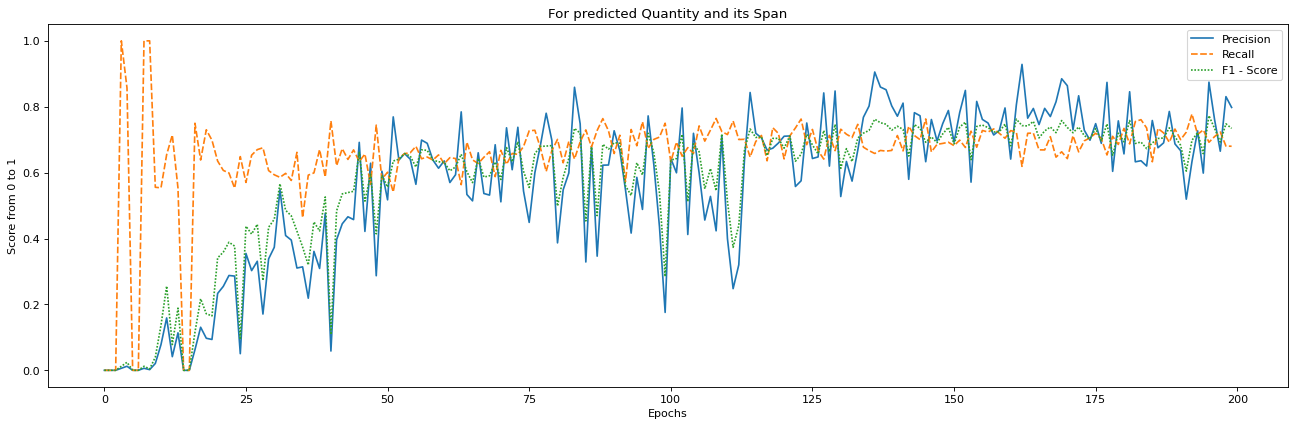

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df['Precision']=precision_Quantity
df['Recall']=recall_Quantity
df['F1 - Score'] = f1_score_Quantity
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("For predicted Quantity and its Span")
sns.lineplot(data=df)

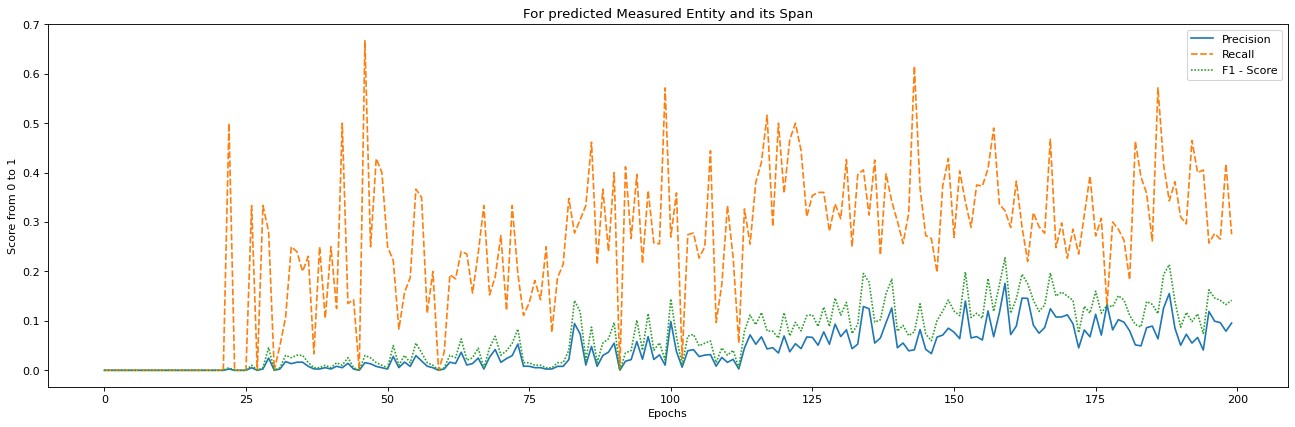

In [12]:
df = pd.DataFrame()
df['Precision']=precision_MeasuredEntity
df['Recall']=recall_MeasuredEntity
df['F1 - Score'] = f1_score_MeasuredEntity
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("For predicted Measured Entity and its Span")
sns.lineplot(data=df)

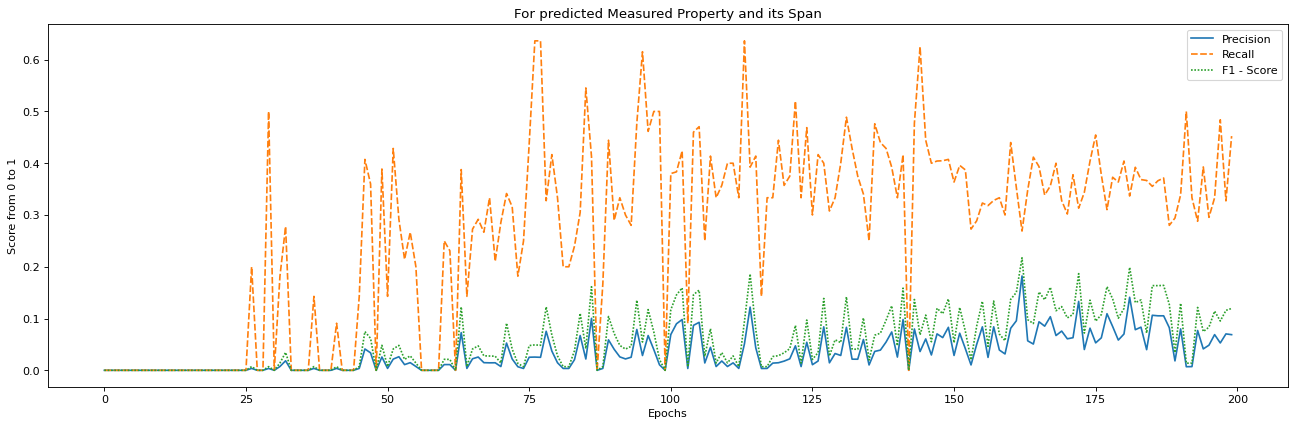

In [13]:
df = pd.DataFrame()
df['Precision']=precision_MeasuredProperty
df['Recall']=recall_MeasuredProperty
df['F1 - Score'] = f1_score_MeasuredProperty
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("For predicted Measured Property and its Span")
sns.lineplot(data=df)

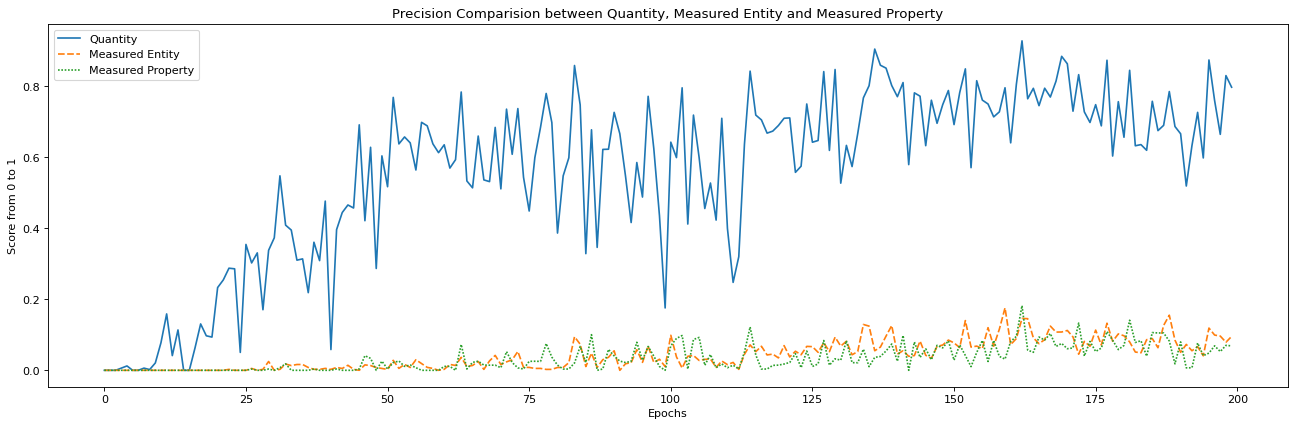

In [14]:
df = pd.DataFrame()
df['Quantity']=precision_Quantity
df['Measured Entity']=precision_MeasuredEntity
df['Measured Property'] = precision_MeasuredProperty
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("Precision Comparision between Quantity, Measured Entity and Measured Property")
sns.lineplot(data=df)

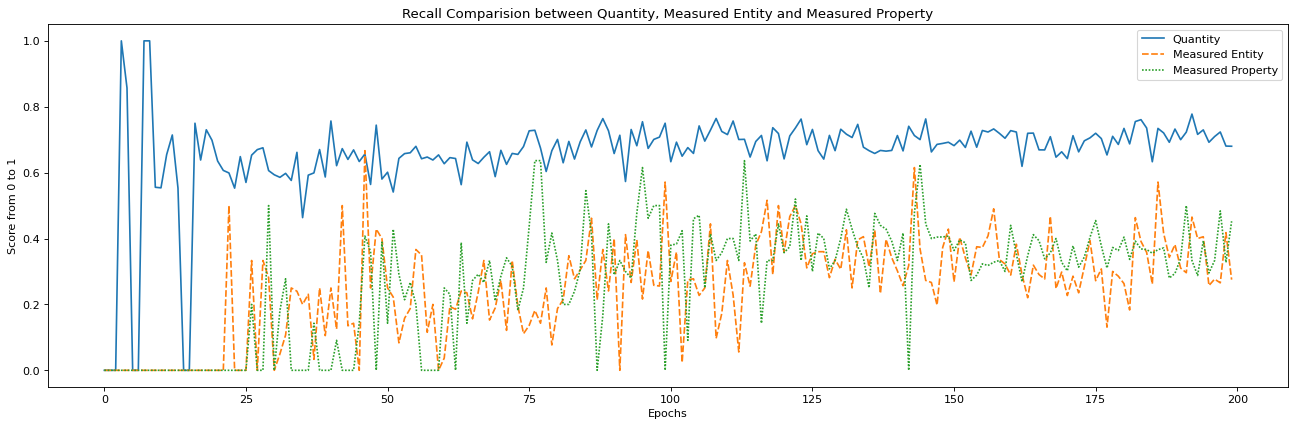

In [15]:
df = pd.DataFrame()
df['Quantity']=recall_Quantity
df['Measured Entity']=recall_MeasuredEntity
df['Measured Property'] = recall_MeasuredProperty
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("Recall Comparision between Quantity, Measured Entity and Measured Property")
sns.lineplot(data=df)

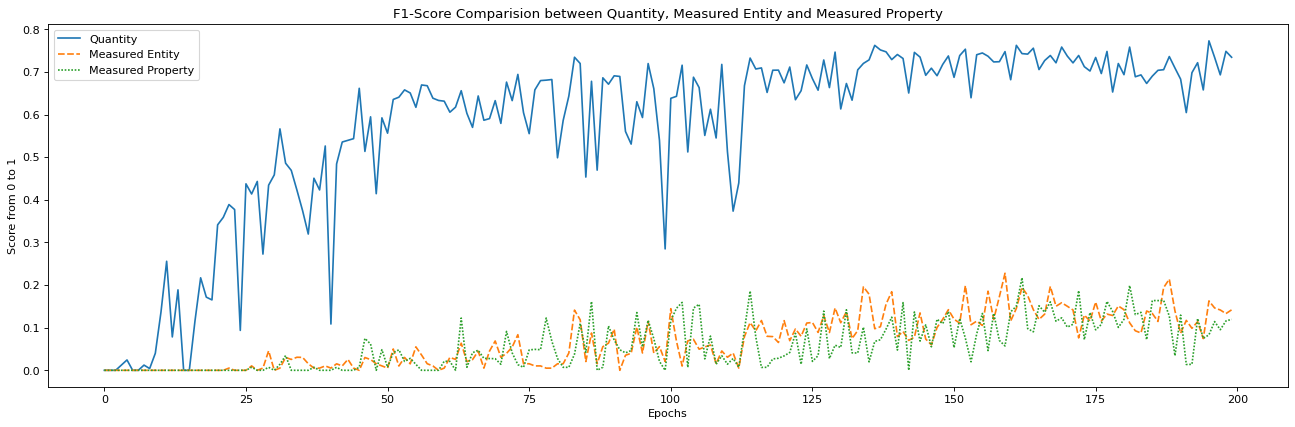

In [16]:
df = pd.DataFrame()
df['Quantity']=f1_score_Quantity
df['Measured Entity']=f1_score_MeasuredEntity
df['Measured Property'] = f1_score_MeasuredProperty
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel("Score from 0 to 1")
plt.xlabel("Epochs")
plt.title("F1-Score Comparision between Quantity, Measured Entity and Measured Property")
sns.lineplot(data=df)

In [17]:
# saving the trained model in a pickle file as it may be time consuming to train the model each time, if required
pickle.dump(nlp, open("nlp_model.pickle", 'wb'))

In [18]:
#loading the saved trained model, which we use to generate TSV files for submission
loaded_model = pickle.load(open("nlp_model.pickle", 'rb'))

In [19]:
def generate_tsv(nlp,X_eval_data,keys_eval_data):
  """ Here we create separate tsv files for each test text document present in /eval/text folder
      and store them in the word_tsv folder in current working directory in google drive.
      NOTE: word_tsv folder must be pre-created in the current working directory in google drive before calling this funtion.
  """

  for i in range(len(X_eval_data)): #iterate through each test text data
    my_path='word_tsv/'+str(keys_eval_data[i])+'.tsv'
    f= open(my_path,"w")
    f.write("docId\tannotSet\tannotType\tstartOffset\tendOffset\tannotId\ttext\tother\n") # writing the header for each file
    annotset={'Quantity':0,'MeasuredProperty':0,'MeasuredEntity':0} #just filling dummy values for annotset
    annotid={'Quantity':'T1-','MeasuredProperty':'T2-','MeasuredEntity':'T3-'} #just filling dummy values for annotid
    doc = nlp(X_eval_data[i])
    for ent in doc.ents:
      temp_tup=(int(ent.start_char),int(ent.end_char),str(ent.label_))
      annotset[str(ent.label_)] += 1
      #dummy values for other field
      other_str=""
      if(str(ent.label_)=="Quantity"):
        other_str = "{\"unit\": \"m\"}"
      if(str(ent.label_)=="MeasuredEntity"):
        other_str = "{\"HasProperty\": \"T2-1\"}"
      if(str(ent.label_)=="MeasuredProperty"):
        other_str = "{\"HasQuantity\": \"T1-1\"}"
      f.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n"%(str(keys_eval_data[i]),str(annotset[str(ent.label_)]),str(ent.label_),str(ent.start_char),str(ent.end_char),str(annotid[str(ent.label_)])+str(annotset[str(ent.label_)]),str(X_eval_data[i][int(ent.start_char):int(ent.end_char)]),other_str))
    f.close()

# calling the function for generating the tsv files of test data present in /eval/text folder
help(generate_tsv)
generate_tsv(loaded_model,X_eval_data,keys_eval_data)

Help on function generate_tsv in module __main__:

generate_tsv(nlp, X_eval_data, keys_eval_data)
    Here we create separate tsv files for each test text document present in /eval/text folder
    and store them in the word_tsv folder in current working directory in google drive.
    NOTE: word_tsv folder must be pre-created in the current working directory in google drive before calling this funtion.

